Value function approximation
init : a model for each action.
per model : input states that is observed by env.reset()
append models

Function featurized_state(state)
preprocess all data in up there, per model by normalizing it.

def predict(state_to_predict, action_to_predict):
1. normalize state
2. return the prediction of features from the model[a]

def update(self, s,a,y):
y = delta or TD target 
1. normalize states(s)
2. fit/back-propagation for (normalized_states, y) at the model[a]
y can be said to be Vpi, sort of an estimated value of V


In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm, trange
import itertools
import random
import time
#Personal library
import sys
if "../" not in sys.path:
  sys.path.append("../") 
from lib import plotting

In [2]:
class Estimator_Neural_Net(nn.Module):
    def __init__(self, n_states, hidden_size, n_pred_actions):
        super().__init__()
        self.linear1 = nn.Linear(n_states, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, n_pred_actions)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(n_states)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        

    def forward(self, states):
        #x = self.normalize(states)
        x = self.relu(self.linear1(states))
        #x = self.normalize(x)
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x #Outputs q_values of actions
    
    
class BackProp:
    def __init__(self, model, lr):
        self.model = model
        self.optimizer = optim.Adam(model.parameters(),lr=lr)
        self.criterion = nn.MSELoss()
       
    def predict_q_values(self, states):
        states = torch.tensor(states, dtype=torch.float)
        states = states.unsqueeze(0)
        return self.model(states) # Prediction from model Q's
    
    def update_model(self, td_target, pred): #Back propagation
        self.optimizer.zero_grad()
        loss = self.criterion(td_target, pred)
        loss.backward()
        self.optimizer.step()

In [3]:
'''
# Personal test functions to make sure we process data properly when back propagating

env = gym.envs.make("MountainCar-v0")
states = env.reset()

model = BackProp(Estimator_Neural_Net(2,3,2), 0.01)

# 1. Preprocess data 
states = torch.tensor(states,dtype=torch.float, requires_grad=True)
state_us = states.unsqueeze(0)

# 2. Predict, td_target is a clone that needs to detach
pred = model.predict_q_values(state_us)
td_target = model.predict_q_values(state_us).clone().detach()

# 3. Update the model with error term
model.update_model(td_target, pred)

# 4. new prediction
new_pred = model.predict_q_values(state_us)
print('states_with_grad',states)
print('states_unsqueeze', state_us)
print('first_pred', pred)
print('new_pred', new_pred)

print('torchmax', torch.max(pred).detach().numpy())
'''
print()

In [4]:
# Policy definitions
# Behavior, target, epsilon decay Definition
# Epsilon Decay per episode.
def update_epsilon(current_episode, max_episodes, initial_e = 1.0, final_e = 0.0):
    r = max((max_episodes-current_episode)/max_episodes,0)
    e = (initial_e-final_e)*r + final_e
    return e

# Behaviour policy : To get all possible action
def epsilon_policy(target_policy,estimator,epsilon,num_actions):
    
    def policy_fn(state): # TODO: Store this function 
        action_values = estimator.predict_q_values(state)
        
        if np.random.random() <= epsilon:
            chosen_action = np.random.choice(num_actions)        
        else:
            chosen_action = target_policy(action_values).item()
        return chosen_action
    return policy_fn

# Target Policy : Choose best action from Q
def greedy_policy(Q):
    return torch.argmax(Q)

In [5]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, initial_e=0.1):
    gamma = discount_factor
    n_actions = env.action_space.n
    n_states = env.observation_space.shape[0]
    stats = plotting.EpisodeStats( episode_lengths=np.zeros(num_episodes),episode_rewards=np.zeros(num_episodes))   

    tqdmloop = trange(num_episodes, desc='ep:', leave=True)
    for ep in tqdmloop:
        tqdmloop.set_description(desc=f"ep[{ep}] ", refresh=True)
        last_reward = stats.episode_rewards[ep - 1]
        
        curr_e = update_epsilon(ep, num_episodes, initial_e = initial_e, final_e = 0.0)
        policy = epsilon_policy(target_policy = greedy_policy, estimator = estimator, epsilon = curr_e, num_actions= n_actions)
        episode = [] # Store state and reward
        
        # Get state and action
        state = env.reset()
        next_action = None
        #action = policy(state)
        
        for t in itertools.count():
            
            if next_action is None:
                #print('doing action')
                action = policy(state)
            else:
                action = next_action
            # S',R
            next_state, reward, game_over, info = env.step(action)
            # A'
            next_action = policy(next_state)
            
            delta =  reward+ (gamma*estimator.predict_q_values(next_state)) - estimator.predict_q_values(state)
            
            # SA = R + S'A
            # Q(SA) = Q_new(R + S'A)
            curr_Q = estimator.predict_q_values(state)
            
            td_target = curr_Q.clone()
            if not game_over: #update td_target
                Q_new = reward + gamma*torch.max(estimator.predict_q_values(next_state))
            else:
                Q_new = reward
            td_target[0][action] = Q_new
            
            # Back propagate our NN with delta
            estimator.update_model(curr_Q,td_target)

            # Update statistics
            stats.episode_rewards[ep] += reward
            stats.episode_lengths[ep] = t
            
            # print stuff
            tqdmloop.set_description(desc=f"Step: {t} @Episode:{ep}/{num_episodes-1}  reward: {last_reward}", refresh=True)
            if game_over:
                break
                
            # Save next values to current value
            state = next_state

    return stats

Step: 9 @Episode:199/199  reward: 9.0: 100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 30.49it/s]


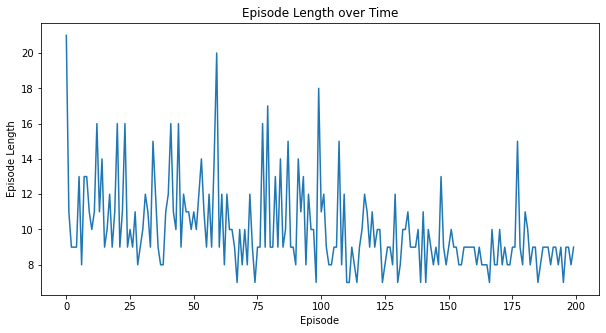

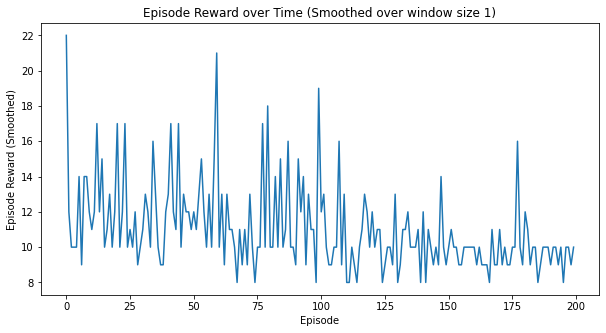

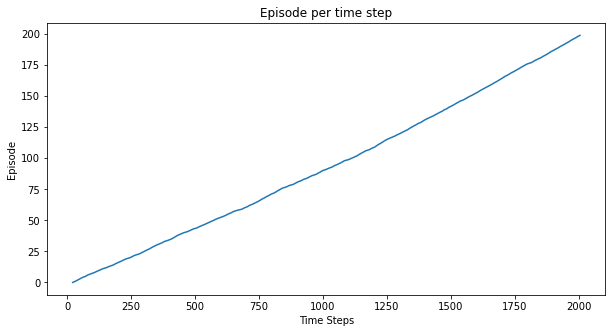

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [11]:
#env = gym.envs.make("MountainCar-v0")
env = gym.envs.make("CartPole-v1")
estimator = BackProp(
    Estimator_Neural_Net(env.observation_space.shape[0],128,env.action_space.n), 
    0.9)

stats = q_learning(env, estimator, 200, 0.5, 0.5)
#plotting.my_plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=1)